In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk9gd_2_6ay.xlsx'
data = pd.read_excel(path, date_parser=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-06-01 00:00:00,151,6,77,243
1,2022-06-01 01:00:00,155,6,78,159
2,2022-06-01 02:00:00,166,16,80,112
3,2022-06-01 03:00:00,169,9,78,99
4,2022-06-01 04:00:00,158,8,78,113


In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d')
#İndex'e Alınması
data.index = data.DATE_TIME

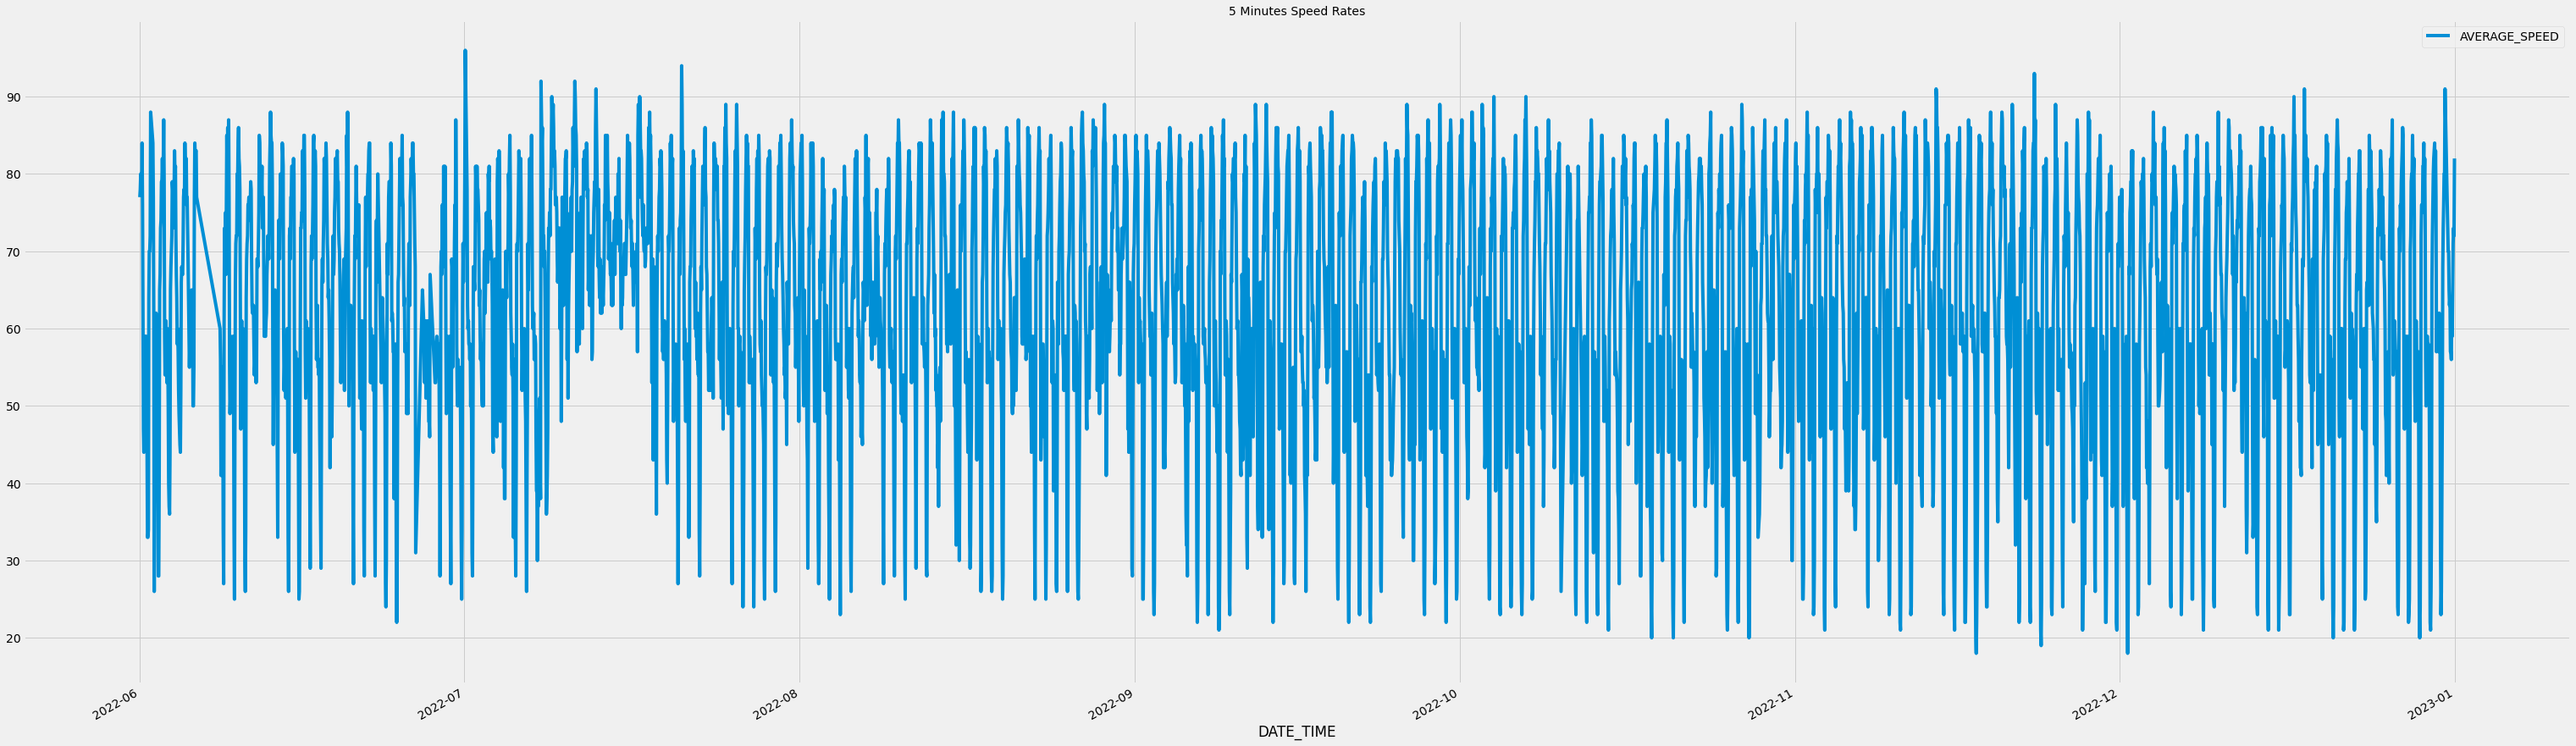

In [4]:
fig = plt.figure(figsize=(48,16))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('5 Minutes Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Seti Sayıları (training set, test set): " + str((len(train), len(test))))
#dataset[train_size:len(dataset)]

Veri Seti Sayıları (training set, test set): (2998, 2000)


In [8]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[(i + window_size), 0])
    return(np.array(data_X), np.array(data_Y))

In [9]:
# Verisetlerimizi Oluşturalım
window_size = 6
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(2991, 6)


In [10]:
def fit_model(train_X, train_Y, window_size):
    model = Sequential()
    # Model X layerlı şekilde kurulacak.
    model.add(Dense(200, activation='relu' ,input_dim = (window_size)))
    model.add(Dense(100, activation='relu' ))
    model.add(Dense(80, activation='relu' ))
    #model.add(Dense(40, activation='relu' ))
    model.add(Dense(1))
    model.compile(loss = "mae", 
                  optimizer = "adam")
   #x epoch yani x kere verisetine bakılacak.
    model.fit(train_X, 
              train_Y, 
              epochs = 1000, 
              batch_size = 32,
              validation_data=(test_X, test_Y),
              verbose = 0)
    
    return(model)
# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

In [11]:
y_test = test_Y.reshape(-1,1)
x_test = test_X
y_train = train_Y.reshape(-1,1)
x_train = train_X

In [12]:
y_train_pred = model1.predict(x_train).reshape(-1,1)
y_test_pred = model1.predict(x_test).reshape(-1,1)
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [13]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 4.13 RMSE
Test data score: 8.35 RMSE


In [14]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)

Train data score: 4.39 MAPE
Test data score: 12.15 MAPE


In [15]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 2.29 MdAPE
Test data score: 6.29 MdAPE


In [16]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 4.26 SMAPE
Test data score: 11.09 SMAPE


In [17]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.40 MASE
Test data score: 0.85 MASE


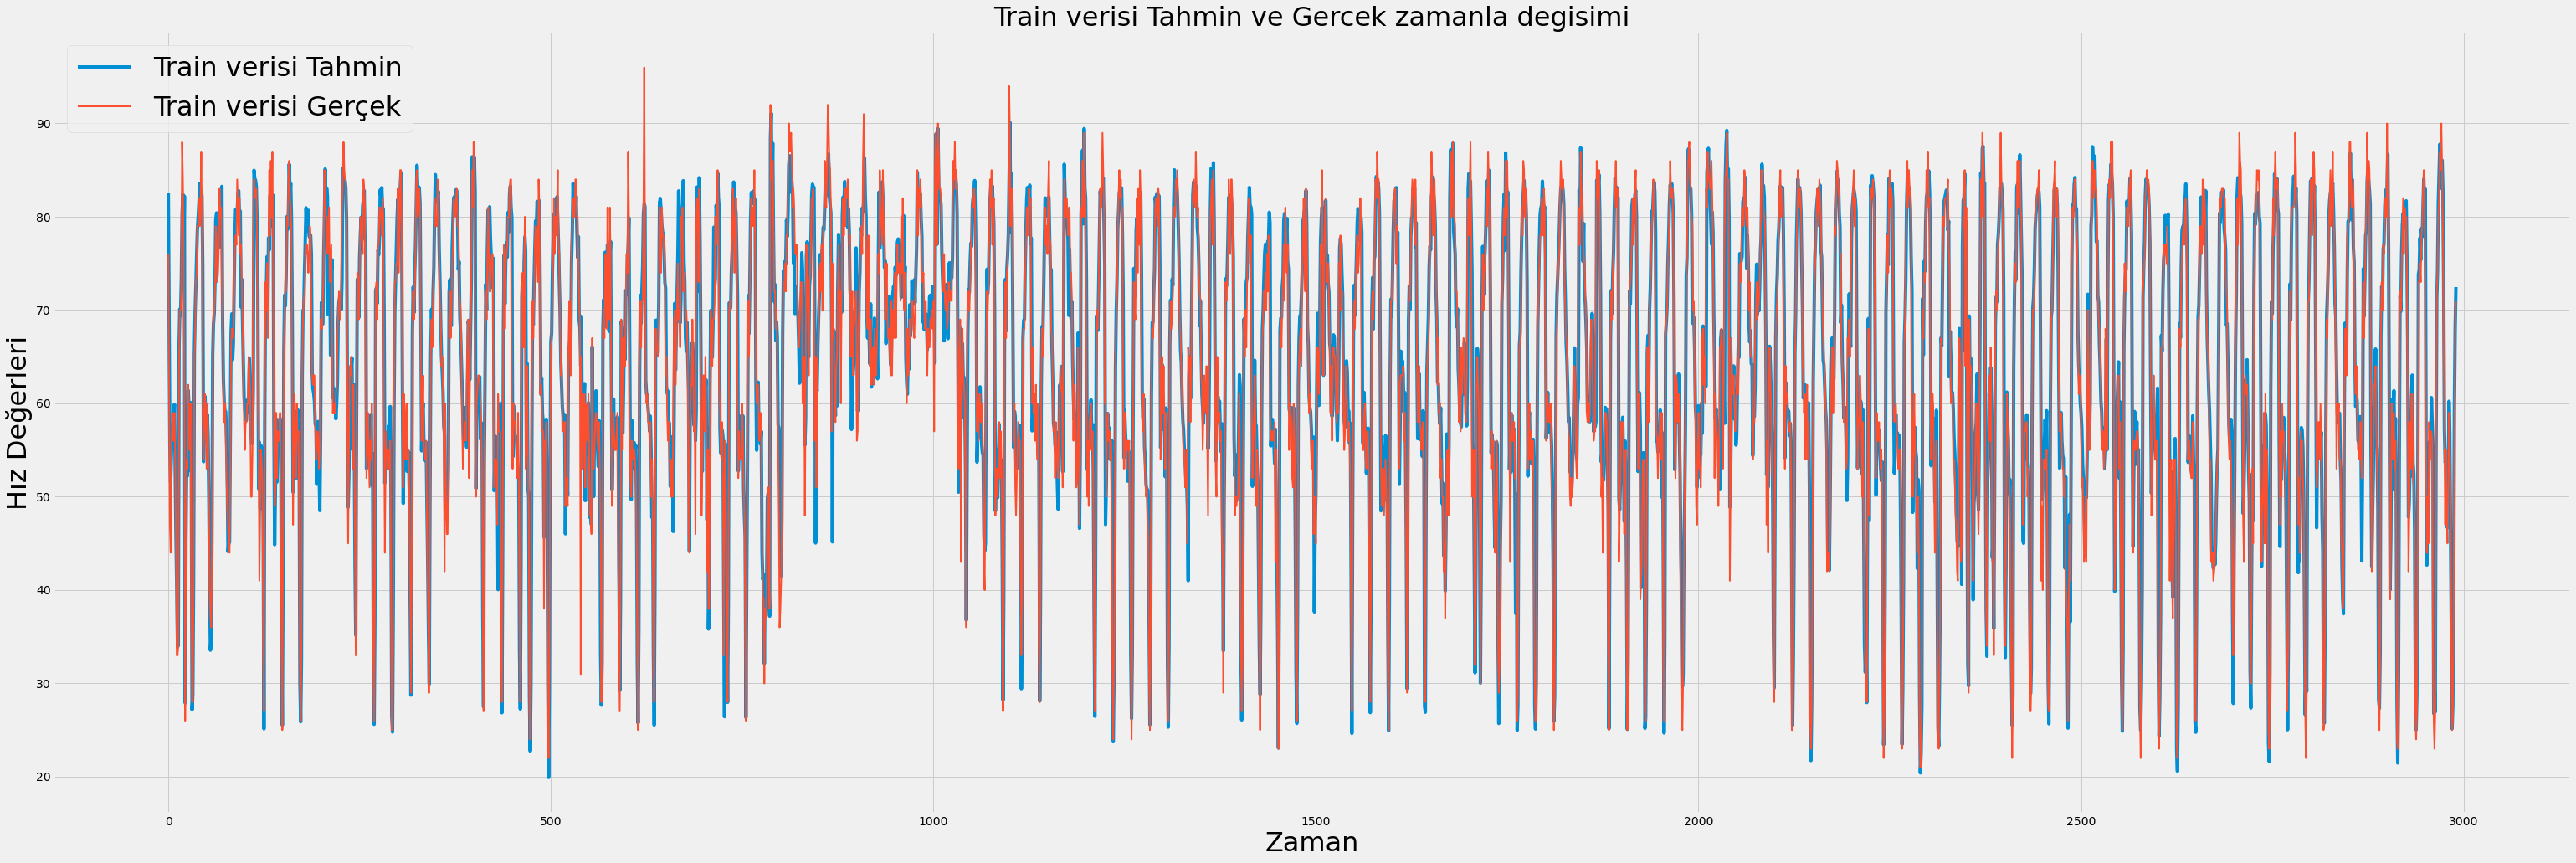

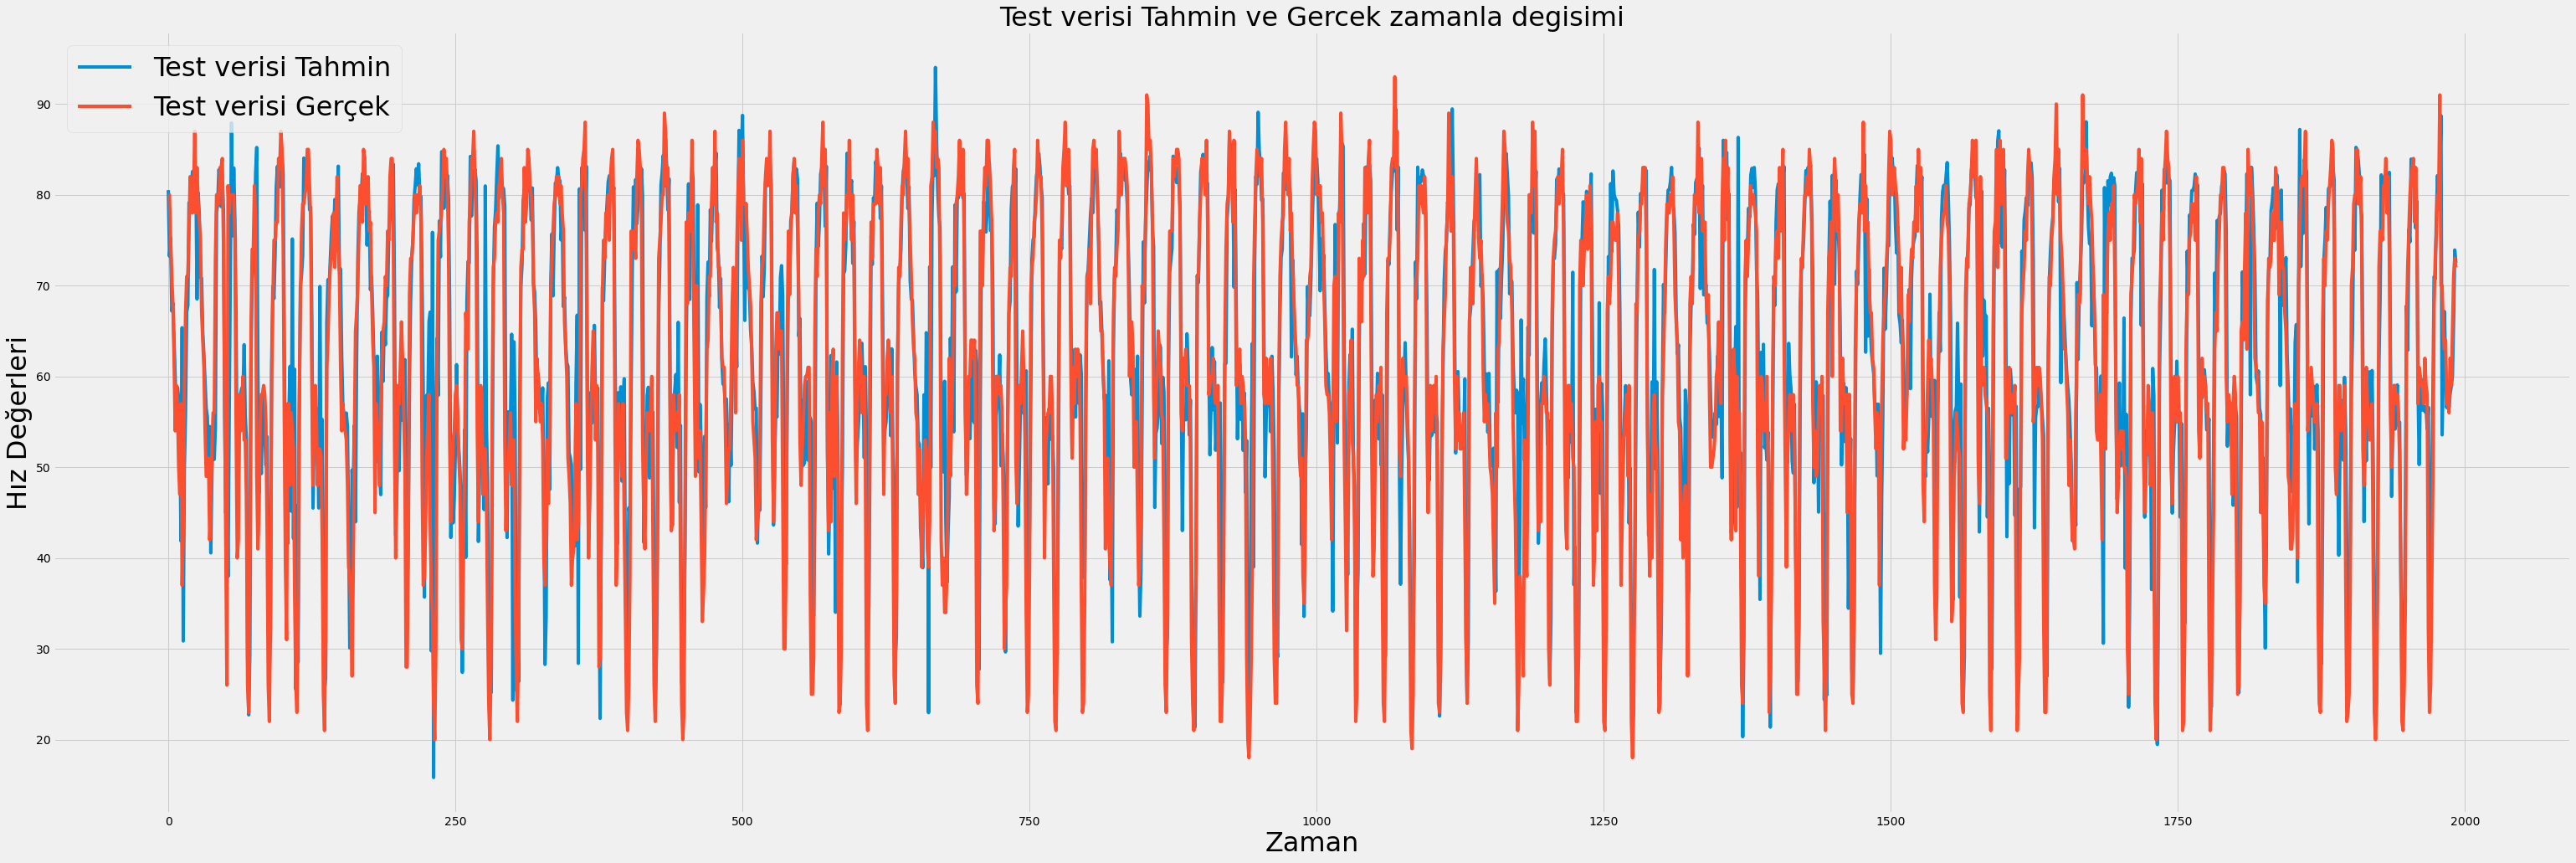

In [18]:
plt.figure(figsize=(48, 16))
plt.plot(y_train_pred, label = "Train verisi Tahmin")
plt.plot(y_train, label = "Train verisi Gerçek" , linewidth=2.0)
plt.title('Train verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()

plt.figure(figsize=(48, 16))
plt.plot(y_test_pred, label = "Test verisi Tahmin")
plt.plot(y_test, label = "Test verisi Gerçek")
plt.title('Test verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()